# Import libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from scipy.stats import chi2_contingency

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 500)



# 1. Load and Prepare dataset

In [2]:
customers = pd.read_csv("./data/customers.csv")
district = pd.read_csv("./data/districts.csv")
transactions = pd.read_csv("./data/transactions.csv")

We aim at predicting loan acceptance to customers. Therefore we obtain for each customer the information related to the district where they live. Then transactional data is incorporated to the dataset. 

In the feature engineering phase, aggregates of the transactional features for each customer will be generated. Therefore, the final model will be trained on data aggregated on customer level. So we can decide whether to grant a loan or not based on the customer specifics characteristics.

In [3]:
# We merge the customer data with transactional data to later on get feature aggregates per transaction.
df = customers.merge(district, on = 'DISTRICT_ID', how = 'left')
df = df.merge(transactions, on = 'ACCOUNT_ID', how = 'left')

In [4]:
# Set date-related features to date format for better processing 
df['BIRTH_DT'] = pd.to_datetime(df['BIRTH_DT'], format='%Y%m%d')

df['DATE'] = df['DATE'].astype(str)
df['DATE'] = df['DATE'].apply(lambda x: x.zfill(8))
df['DATE'] = pd.to_datetime(df['DATE'], format='%d%m%Y')

In [5]:
# Set indexes, sort the dataframe by date
df = df.set_index(['SET_SPLIT', 'CLIENT_ID', 'ACCOUNT_ID', 'DISTRICT_ID', 'BIRTH_DT', 'DATE'])
df = df.rename(columns={'LOAN':'TARGET'})
df = df.sort_values(by='DATE')
df = df.drop(columns=['TRANS_ID', 'ACTIVE']) # TRANS_ID is irrelevant and ACTIVE = 1 for all instances

## 1.1 Handling missing values

In [6]:
# check missing values per column
df.isna().sum().sort_values(ascending=False)

OPERATION      181914
TARGET          12568
GENDER              0
N_INHAB             0
N_CITIES            0
URBAN_RATIO         0
AVG_SALARY          0
UNEMP_95            0
UNEMP_96            0
N_ENTR              0
CRIME_95            0
CRIME_96            0
AMOUNT              0
BALANCE             0
TYPE                0
dtype: int64

In [7]:
# drop missing values from the TARGET column and set a new category in the OPERATION column as 'OTHER'
df = df.dropna(subset=['TARGET'])
df.loc[df['OPERATION'].isnull(), 'OPERATION'] = 'OTHER'

In [8]:
# The columns CRIME_95 and UNEMP_95 have '?' strings that can be imputed
# Convert 'CRIME_95' and 'UNEMP_95' columns to numeric
df['CRIME_95'] = pd.to_numeric(df['CRIME_95'], errors='coerce')
df['UNEMP_95'] = pd.to_numeric(df['UNEMP_95'], errors='coerce')

# Calculate the average (mean) of each column
crime_mean = df['CRIME_95'].mean()
unemp_mean = df['UNEMP_95'].mean()

# Impute '?' values with the calculated averages
df['CRIME_95'].fillna(crime_mean, inplace=True)
df['UNEMP_95'].fillna(unemp_mean, inplace=True)

## 1.2 Removing Duplicates

In [9]:
# Drop duplicated rows
df = df.drop_duplicates()

## 1.3 Outlier Detection and Treatment

In [10]:
# Detect outliers for all numerical variables using the IQR method
cat_variables = ['GENDER', 'TYPE', 'OPERATION', 'TARGET']
num_variables = list(set(df.columns).difference(set(cat_variables)))

In [11]:
q1 = df[num_variables].describe().loc['25%']
q3 = df[num_variables].describe().loc['75%']
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = (df[num_variables] <= lower_bound) | (df[num_variables] >= upper_bound)

In [12]:
outliers.sum()

UNEMP_96        10752
AMOUNT         116559
AVG_SALARY     123820
URBAN_RATIO         0
N_ENTR              0
UNEMP_95        10752
N_INHAB        123820
N_CITIES            0
BALANCE         33889
CRIME_96       190036
CRIME_95       200724
dtype: int64

- The variables AMOUNT and AVG_SALARY  per se expected to be left skewed and having outlierts
- Similarly, the variable CRIME_96, N_INHAB and UNEMP_96 are district-specific and they reflect societal differences across districts, which is expected to have outliers.

Based on the above, no treatment will be taken for outliers since they are part of the feature distribution of the customer's and demographic characteristics.

## 1.4 Feature Engineering


### 1.4.1 Calculate Customer Age

In [13]:
df = df.reset_index()

In [14]:
max_date = df['DATE'].max()
df['AGE'] = (max_date - df['BIRTH_DT']).dt.days // 365

In [15]:
# We drop ilogical values such as minors in the dataframe. We only keep customers with age higher than 18
df = df.loc[df['AGE'] >= 18]

### 1.4.2 Create AMOUNT and BALANCE aggregation statistics variables: overage aggregation, monthly, yearly, and ratios

In [16]:
# For each customer we calculate the mean, sum, standard deviation and count of AMOUNT and BALANCE. 
aggregated_df = df.groupby(['CLIENT_ID'])[['AMOUNT', 'BALANCE']].agg(['mean', 'sum', 'std','count']).reset_index()
aggregated_df.columns = [col[0] + ":" + col[1].capitalize() if index != 0 else col[0] for index, col in enumerate(aggregated_df.columns)]
df = df.merge(aggregated_df, on=['CLIENT_ID'], how='left')

In [17]:
aggregated_df = df.groupby([df['CLIENT_ID'], df['DATE'].dt.month])[['AMOUNT', 'BALANCE']].agg(['mean', 'sum', 'std']).reset_index()
aggregated_df.columns = ["MONTHLY_" + col[0] + ":" + col[1].capitalize() if index not in [0, 1] else col[0] for index, col in enumerate(aggregated_df.columns)]
df = df.merge(aggregated_df.drop(columns='DATE'), on=['CLIENT_ID'], how='left')

In [18]:
aggregated_df = df.groupby([df['CLIENT_ID'], df['DATE'].dt.year])[['AMOUNT', 'BALANCE']].agg(['mean', 'sum', 'std']).reset_index()
aggregated_df.columns = ["YEARLY_" + col[0] + ":" + col[1].capitalize() if index not in [0, 1] else col[0] for index, col in enumerate(aggregated_df.columns)]
df = df.merge(aggregated_df.drop(columns='DATE'), on=['CLIENT_ID'], how='left')

In [19]:
df['RATIO_MONTHLY_AMOUNT_BALANCE:mean'] = df['MONTHLY_AMOUNT:Mean'] / df['MONTHLY_BALANCE:Mean']
df['RATIO_MONTHLY_AMOUNT_BALANCE:Sum'] = df['MONTHLY_AMOUNT:Sum'] / df['MONTHLY_BALANCE:Sum']
df['RATIO_MONTHLY_AMOUNT_BALANCE:Std'] = df['MONTHLY_AMOUNT:Std'] / df['MONTHLY_BALANCE:Std']

df['RATIO_AMOUNT_BALANCE:mean'] = df['AMOUNT:Mean'] / df['BALANCE:Mean']
df['RATIO_AMOUNT_BALANCE:Sum'] = df['AMOUNT:Sum'] / df['BALANCE:Sum']
df['RATIO_AMOUNT_BALANCE:Std'] = df['AMOUNT:Std'] / df['BALANCE:Std']


df['RATIO_YEARLY_AMOUNT_BALANCE:mean'] = df['YEARLY_AMOUNT:Mean'] / df['YEARLY_BALANCE:Mean']
df['RATIO_YEARLY_AMOUNT_BALANCE:Sum'] = df['YEARLY_AMOUNT:Sum'] / df['YEARLY_BALANCE:Sum']
df['RATIO_YEARLY_AMOUNT_BALANCE:Std'] = df['YEARLY_AMOUNT:Std'] / df['YEARLY_BALANCE:Std']

## 1.5 Aggregate data for final modelling

In [20]:
# By calculating the max value for the below columns we ensure a level of customer aggregation as in the customers.csv file
vars_to_agg = df.columns.tolist()

In [21]:
if 'CLIENT_ID' in vars_to_agg:
    vars_to_agg.remove('CLIENT_ID')

if 'TYPE' in vars_to_agg:
    vars_to_agg.remove('TYPE')
    
if 'OPERATION' in vars_to_agg:
    vars_to_agg.remove('OPERATION')

In [22]:
temp1 = df.groupby('CLIENT_ID')[vars_to_agg].max()
temp2 = df.groupby('CLIENT_ID')['TYPE'].agg(lambda x: x.value_counts().idxmax())
temp3 = df.groupby('CLIENT_ID')['OPERATION'].agg(lambda x: x.value_counts().idxmax())

In [23]:
df = temp1.merge(temp2, on='CLIENT_ID', how = 'left').reset_index()
df = df.merge(temp3, on='CLIENT_ID', how = 'left')

In [24]:
df = df.drop(columns=['ACCOUNT_ID', 'DISTRICT_ID', 'BIRTH_DT', 'DATE'])
df = df.rename(columns={'TYPE': 'MOST_COMMON_TRANS_TYPE', 'OPERATION':'MOST_COMMON_TRANS_OPERATION'})
df = df.set_index(['SET_SPLIT', 'CLIENT_ID'])
df = df.sort_index(axis=1)

## 1.6 Encoding Categorical Variables:

In [25]:
# We do One-hot encoding on the OPERATION, TYPE and GENDER variables variable since it is multinomial and later on will be used for getting the count of instances when aggregating
loan_data_dummies = [pd.get_dummies(df['MOST_COMMON_TRANS_OPERATION'], prefix = 'MOST_COMMON_TRANS_OPERATION', prefix_sep = ':'),
                     pd.get_dummies(df['MOST_COMMON_TRANS_TYPE'], prefix = 'MOST_COMMON_TRANS_TYPE', prefix_sep = ':'),
                     pd.get_dummies(df['GENDER'], prefix = 'GENDER', prefix_sep = ':')]

In [26]:
loan_data_dummies = pd.concat(loan_data_dummies, axis = 1)

In [27]:
df = pd.concat([df, loan_data_dummies], axis = 1)

# 2. Exploratory Data Analysis

In [28]:
num_variables = ['AGE', 'AMOUNT', 'AMOUNT:Count', 'AMOUNT:Mean', 'AMOUNT:Std',
       'AMOUNT:Sum', 'AVG_SALARY', 'BALANCE', 'BALANCE:Count', 'BALANCE:Mean',
       'BALANCE:Std', 'BALANCE:Sum', 'CRIME_95', 'CRIME_96',
       'MONTHLY_AMOUNT:Mean', 'MONTHLY_AMOUNT:Std', 'MONTHLY_AMOUNT:Sum',
       'MONTHLY_BALANCE:Mean', 'MONTHLY_BALANCE:Std', 'MONTHLY_BALANCE:Sum', 'N_CITIES',
       'N_ENTR', 'N_INHAB', 'RATIO_AMOUNT_BALANCE:Std',
       'RATIO_AMOUNT_BALANCE:Sum', 'RATIO_AMOUNT_BALANCE:mean',
       'RATIO_MONTHLY_AMOUNT_BALANCE:Std', 'RATIO_MONTHLY_AMOUNT_BALANCE:Sum',
       'RATIO_MONTHLY_AMOUNT_BALANCE:mean', 'RATIO_YEARLY_AMOUNT_BALANCE:Std',
       'RATIO_YEARLY_AMOUNT_BALANCE:Sum', 'RATIO_YEARLY_AMOUNT_BALANCE:mean',
       'UNEMP_95', 'UNEMP_96', 'URBAN_RATIO', 'YEARLY_AMOUNT:Mean',
       'YEARLY_AMOUNT:Std', 'YEARLY_AMOUNT:Sum', 'YEARLY_BALANCE:Mean',
       'YEARLY_BALANCE:Std', 'YEARLY_BALANCE:Sum']

cat_variables = ['GENDER', 'MOST_COMMON_TRANS_OPERATION',
       'MOST_COMMON_TRANS_TYPE']

In [29]:
trace0 = go.Bar(
    x = df[df["TARGET"]== 0]["TARGET"].value_counts().index.values,
    y = df[df["TARGET"]== 0]["TARGET"].value_counts().values,
    name='Good credit',
    marker=dict(color='blue')
)

trace1 = go.Bar(
    x = df[df["TARGET"]== 1]["TARGET"].value_counts().index.values,
    y = df[df["TARGET"]== 1]["TARGET"].value_counts().values,
    name='Bad credit',
    marker=dict(color='red')
)

data = [trace0, trace1]

layout = go.Layout(
    title='Target Variable Distribution',
    width=600,
    margin=dict(l=50, r=50, b=50, t=50, pad=4),
    yaxis=dict(title='Count'),
    xaxis=dict(title='TARGET Variable'),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig = go.Figure(data=data, layout=layout)
fig.show()


In [30]:
# First plot
trace0 = go.Bar(
    x=df[df['TARGET'] == 0]['MOST_COMMON_TRANS_TYPE'].value_counts().index.values,
    y=df[df['TARGET'] == 0]['MOST_COMMON_TRANS_TYPE'].value_counts().values,
    name='Good Credit Distribution',
    marker=dict(color='#636EFA')
)

# Second plot
trace1 = go.Bar(
    x=df[df['TARGET'] == 1]['MOST_COMMON_TRANS_TYPE'].value_counts().index.values,
    y=df[df['TARGET'] == 1]['MOST_COMMON_TRANS_TYPE'].value_counts().values,
    name='Bad Credit Distribution',
    marker=dict(color='#EF553B')
)

data = [trace0, trace1]

layout = go.Layout(
    title='Most Frequent Type of Transaction',
    xaxis=dict(title='Type of Transaction'),
    yaxis=dict(title='Count'),
    barmode='group',
    width=1000,
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(family='Arial, sans-serif', size=14, color='#7f7f7f')
)

fig = go.Figure(data=data, layout=layout)

fig.show()


In [31]:
# Calculate the count of each risk and sex combination
df_counts = df.groupby(['TARGET', 'GENDER']).size().reset_index(name='count')

# Define colors based on gender and credit risk
color_mapping = {
    (0, 'M'): '#7FBFFF',
    (0, 'F'): '#B6E2FF',
    (1, 'M'): '#FF7F7F',
    (1, 'F'): '#FFB6B6'
}

# Create the stacked bar chart
fig = go.Figure(data=[
    go.Bar(name='Male', 
           x=df_counts[df_counts['GENDER'] == 'M']['TARGET'], 
           y=df_counts[df_counts['GENDER'] == 'M']['count'], 
           marker=dict(color=[color_mapping[(risk, 'M')] for risk in df_counts[df_counts['GENDER'] == 'M']['TARGET']])),
    go.Bar(name='Female', 
           x=df_counts[df_counts['GENDER'] == 'F']['TARGET'], 
           y=df_counts[df_counts['GENDER'] == 'F']['count'], 
           marker=dict(color=[color_mapping[(risk, 'F')] for risk in df_counts[df_counts['GENDER'] == 'F']['TARGET']])),
])

# Update layout
fig.update_layout(title='Credit Risk by Gender',
                  xaxis_title='Risk',
                  yaxis_title='Count',
                  barmode='stack',
                  width=800,
                  template="simple_white",
                  legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1))

# Show the plot
fig.show()


In [32]:
df_good = df.loc[df["TARGET"] == 0]['AGE'].values.tolist()
df_bad = df.loc[df["TARGET"] == 1]['AGE'].values.tolist()
df_age = df['AGE'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit",
    marker=dict(color='blue')
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit",
    marker=dict(color='red')
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age",
    marker=dict(color='gray')
)

#Creating the grid
fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig.update_layout(
    title='Age Distribution',
    template='plotly_white',
    width=1000,
    height=600,
    margin=dict(l=50, r=50, t=80, b=80),
    showlegend=True,
    bargap=0.05,
    xaxis=dict(title='Age'),
    yaxis=dict(title='Probability')
)

fig.show()


In [33]:
#Let's look the Credit Amount column
interval = (18, 35, 60, 120)

cats = ['Young', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df['AGE'], interval, labels=cats)


df_good = df[df["TARGET"] == 0]
df_bad = df[df["TARGET"] == 1]

# Create a subplot with two rows and one column
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=['Max Daily Transaction Amount by Age Category', 'Max Daily Balance by Age Category'])

# Box plot for "Max Transaction Amount"
trace0 = go.Box(
    y=df_good["AMOUNT"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(color='blue')
)

trace1 = go.Box(
    y=df_bad['AMOUNT'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(color='red')
)

fig.add_trace(trace0, row=1, col=1)
fig.add_trace(trace1, row=1, col=1)

# Box plot for "Max Daily Balance"
trace2 = go.Box(
    y=df_good["BALANCE"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(color='blue')
)

trace3 = go.Box(
    y=df_bad['BALANCE'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(color='red')
)

fig.add_trace(trace2, row=2, col=1)
fig.add_trace(trace3, row=2, col=1)

# Customize the layout
fig.update_layout(
    yaxis=dict(title='Max Daily Transaction Amount', zeroline=False),
    yaxis2=dict(title='Max Daily Balance', zeroline=False),
    xaxis=dict(title='Age Categorical'),
    boxmode='group',
    font=dict(family="Arial, sans-serif", size=14, color="#7f7f7f"),
    margin=dict(l=30, r=30, b=30, t=80),
    showlegend=True,
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000,
    height=800
)

# Update subplot titles
fig.update_annotations(selector=dict(title='Max Daily Transaction Amount by Age Category'), font=dict(size=16))
fig.update_annotations(selector=dict(title='Max Daily Balance by Age Category'), font=dict(size=16))

# Show the combined figure
fig.show()


In [34]:
#First plot
trace0 = go.Bar(
    x = df[df["TARGET"]== 0]["MOST_COMMON_TRANS_OPERATION"].value_counts().index.values,
    y = df[df["TARGET"]== 0]["MOST_COMMON_TRANS_OPERATION"].value_counts().values,
    name='Good credit',
    marker=dict(
        color='blue' # blue color
    )
)

#Second plot
trace1 = go.Bar(
    x = df[df["TARGET"]== 1]["MOST_COMMON_TRANS_OPERATION"].value_counts().index.values,
    y = df[df["TARGET"]== 1]["MOST_COMMON_TRANS_OPERATION"].value_counts().values,
    name="Bad Credit",
    marker=dict(
        color='red' # red color
    )
)

data = [trace0, trace1]

layout = go.Layout(
    title='Type of Operation Distribuition',
    width=1000,
    height=500,
    plot_bgcolor='white',
    xaxis=dict(
        title='Operation Type',
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title='Count',
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    font=dict(
        family='Arial, sans-serif',
        size=14,
        color='black'
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()


In [35]:
# Create histogram traces
trace1 = go.Histogram(x=df_good['AMOUNT'], name='Good Credit', marker=dict(color='blue'), nbinsx=50)
trace2 = go.Histogram(x=df_bad['AMOUNT'], name='Bad Credit', marker=dict(color='red'), nbinsx=50)

# Define layout
layout = go.Layout(
    title='Max Daily Transaction Frequency Distribution',
    xaxis=dict(title='AMOUNT'),
    yaxis=dict(title='Count'),
    width=1000,
    template="simple_white"
)

# Create figure object
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Display the plot
fig.show()


In [36]:
df = df.drop(columns=['Age_cat'])

### Correlation Analysis (Continuous Variables)

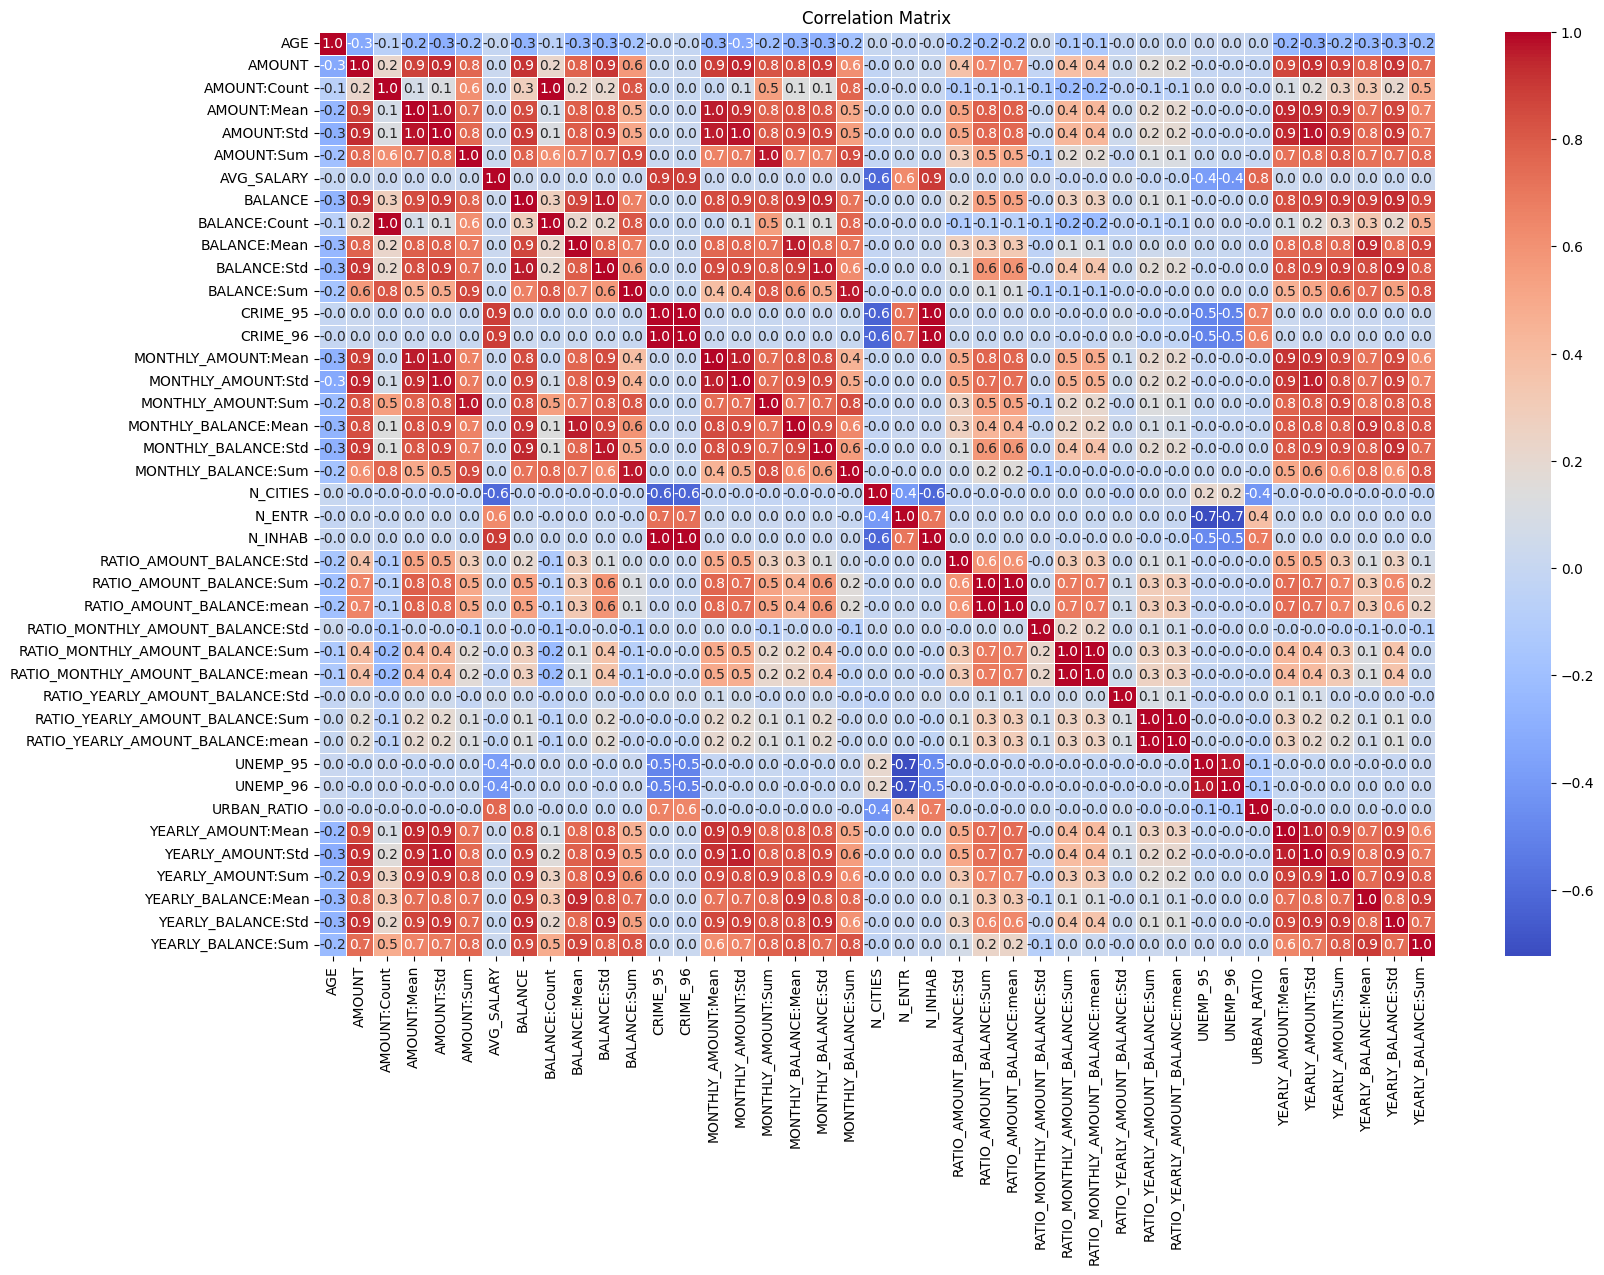

In [37]:
# First we calculate the correlation between all numerical variables

correlation_matrix = df[num_variables].corr()

plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [38]:
# We calculate the variation inflation factor (VIF) to better assess the results from the correlation matrix
df = df.replace([np.inf, -np.inf], np.nan)
df[num_variables] = df[num_variables].apply(lambda x: x.fillna(x.mean()), axis=0)

vif_data = pd.DataFrame()
vif_data["Variable"] = df[num_variables].columns
vif_data["VIF"] = [variance_inflation_factor(df[num_variables].values, i) for i in range(df[num_variables].shape[1])]

vif_data[vif_data['VIF'] < 10]

,Variable,VIF
0,AGE,9.043756
20,N_CITIES,8.283615
26,RATIO_MONTHLY_AMOUNT_BALANCE:Std,1.132374
29,RATIO_YEARLY_AMOUNT_BALANCE:Std,1.083142


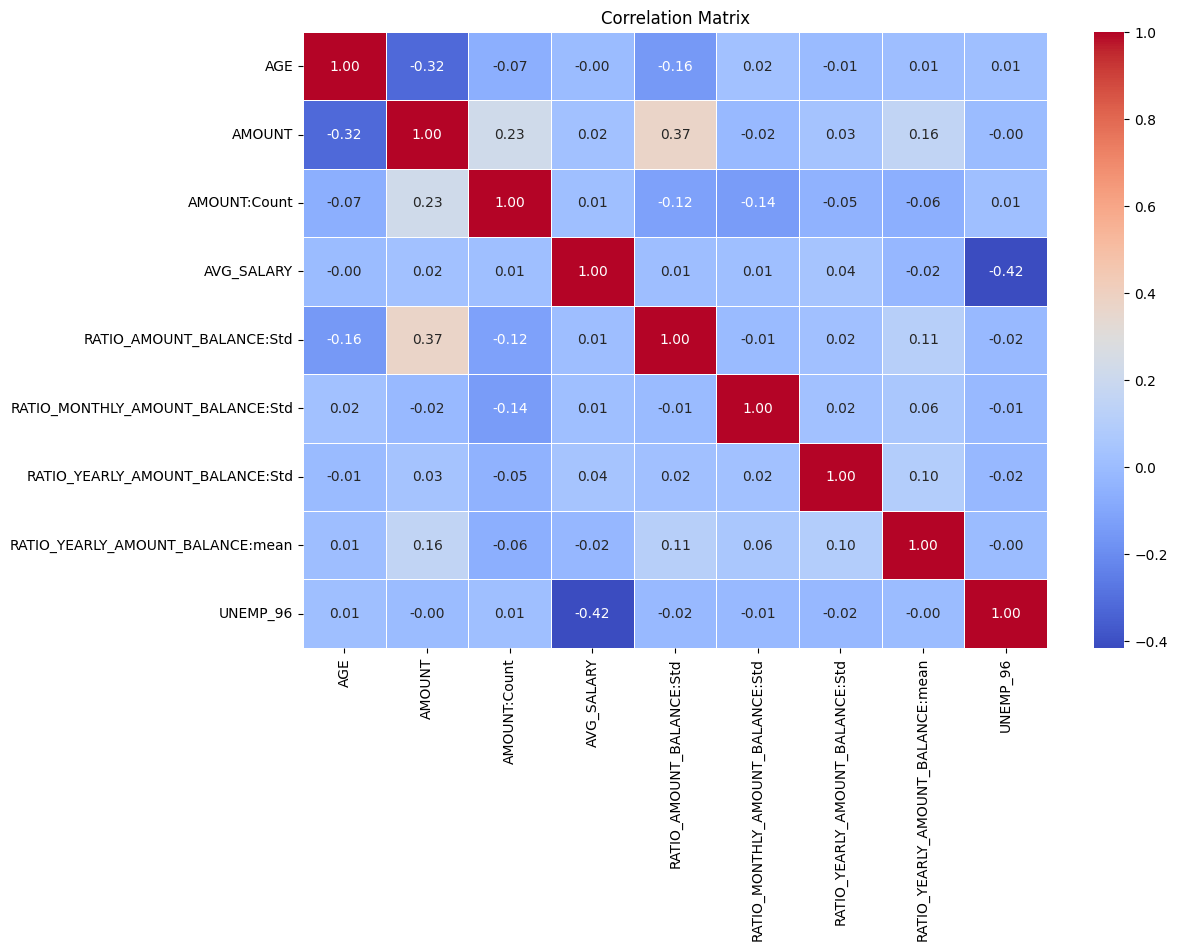

In [39]:
# Based on the results from the correlation matrix and VIF, we decide for the following numerical variables to keep
final_numerical_variables = ['AGE','AMOUNT','AMOUNT:Count','AVG_SALARY',
    'RATIO_AMOUNT_BALANCE:Std','RATIO_MONTHLY_AMOUNT_BALANCE:Std','RATIO_YEARLY_AMOUNT_BALANCE:Std',
    'RATIO_YEARLY_AMOUNT_BALANCE:mean','UNEMP_96']

correlation_matrix = df[final_numerical_variables].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [40]:
num_vars_to_drop = set(num_variables).difference(final_numerical_variables)
df = df.drop(columns=num_vars_to_drop)

### Chi-squared test of independence (categorical variables)

In [41]:
results = {}
for i in range(len(cat_variables)):
    for j in range(i + 1, len(cat_variables)):
        cross_table = pd.crosstab(df[cat_variables[i]], df[cat_variables[j]])
        chi2, p, dof, expected = chi2_contingency(cross_table)
        results[f"{cat_variables[i]} vs {cat_variables[j]}"] = {'Chi-Squared': chi2, 'P-value': p}

results_df = pd.DataFrame.from_dict(results, orient='index')

results_df

,Chi-Squared,P-value
GENDER vs MOST_COMMON_TRANS_OPERATION,3.067850,0.546536
GENDER vs MOST_COMMON_TRANS_TYPE,0.323476,0.569526
MOST_COMMON_TRANS_OPERATION vs MOST_COMMON_TRANS_TYPE,1588.020362,0.000000


The results of the chi-squared test show that there is a statistically significant association between the variables 'MOST_COMMON_TRANS_OPERATION' and 'MOST_COMMON_TRANS_TYPE' (chi-squared test statistic = 1588, p-value = <0.001). This suggests that the likelihood both variables are dependent of each other. Suggesting that we can drop one of them.

In [49]:
num_vars_to_drop = df.columns[df.columns.str.contains("TYPE")]
df = df.drop(columns=num_vars_to_drop)

# Splitting Data

In [46]:
df.head()

AGE   AMOUNT  AMOUNT:Count  AVG_SALARY GENDER  \
SET_SPLIT CLIENT_ID                                                  
TRAIN     1           28  12600.0           239        8968      F   
          2           53  42000.0           468       12541      M   
TEST      4           42  11253.0           114        9307      M   
TRAIN     7           69   5100.0            83        9045      M   
          8           60  11600.0           245        8541      F   

                    MOST_COMMON_TRANS_OPERATION MOST_COMMON_TRANS_TYPE  \
SET_SPLIT CLIENT_ID                                                      
TRAIN     1                  WITHDRAWAL_IN_CASH             WITHDRAWAL   
          2                  WITHDRAWAL_IN_CASH             WITHDRAWAL   
TEST      4            REMITTANCE_TO_OTHER_BANK             WITHDRAWAL   
TRAIN     7                  WITHDRAWAL_IN_CASH             WITHDRAWAL   
          8                  WITHDRAWAL_IN_CASH             WITHDRAWAL   

                     RATIO_AMOUNT_BALANCE:Std  \
SET_SPLIT CLIENT_ID                             
TRAIN     1                          0.473676   
          2                          0.693448   
TEST      4                          0.287445   
TRAIN     7                          0.505457   
          8                          0.361528   

                     RATIO_MONTHLY_AMOUNT_BALANCE:Std  \
SET_SPLIT CLIENT_ID                                     
TRAIN     1                                  0.935318   
          2                                  0.927735   
TEST      4                                  1.239189   
TRAIN     7                                  1.314700   
          8                                  0.598730   

                     RATIO_YEARLY_AMOUNT_BALANCE:Std  \
SET_SPLIT CLIENT_ID                                    
TRAIN     1                                 0.692325   
          2                                 0.870251   
TEST      4                                 0.570073   
TRAIN     7                                 0.708479   
          8                                 0.671780   

                     RATIO_YEARLY_AMOUNT_BALANCE:mean  TARGET  UNEMP_96  \
SET_SPLIT CLIENT_ID                                                       
TRAIN     1                                  0.106844     0.0      3.35   
          2                                  0.250617     1.0      0.43   
TEST      4                                  0.164192     0.0      4.43   
TRAIN     7                                  0.109408     0.0      3.60   
          8                                  0.479364     0.0      2.97   

                     MOST_COMMON_TRANS_OPERATION:COLLECTION_FROM_OTHER_BANK  \
SET_SPLIT CLIENT_ID                                                           
TRAIN     1                                                          0        
          2                                                          0        
TEST      4                                                          0        
TRAIN     7                                                          0        
          8                                                          0        

                     MOST_COMMON_TRANS_OPERATION:CREDIT_IN_CASH  \
SET_SPLIT CLIENT_ID                                               
TRAIN     1                                                   0   
          2                                                   0   
TEST      4                                                   0   
TRAIN     7                                                   0   
          8                                                   0   

                     MOST_COMMON_TRANS_OPERATION:OTHER  \
SET_SPLIT CLIENT_ID                                      
TRAIN     1                                          0   
          2                                          0   
TEST      4                                          0   
TRAIN     7                       

In [44]:
X = df.drop('TARGET', axis = 1)
y = df['TARGET']

In [45]:
loan_data_inputs_train = X[X.index.get_level_values('SET_SPLIT') == 'TRAIN']
loan_data_targets_train = y[y.index.get_level_values('SET_SPLIT') == 'TRAIN']
loan_data_inputs_test = X[X.index.get_level_values('SET_SPLIT') == 'TEST']
loan_data_targets_test = y[y.index.get_level_values('SET_SPLIT') == 'TEST']

## Weight of Evidence (WoE) transformation

In [ ]:
# ####
df_inputs_prepr = loan_data_inputs_train
df_targets_prepr = loan_data_targets_train
####
# df_inputs_prepr = loan_data_inputs_test
# df_targets_prepr = loan_data_targets_test

In [ ]:
# WoE function for discrete unordered variables
def woe_discrete(df:pd.DataFrame, discrete_variabe_name:str, good_bad_variable_df:pd.DataFrame) -> pd.DataFrame:
    epsilon = 1e-6  # A small constant to prevent division by zero
    # Concatenates two dataframes along the columns.
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    # Here we calculate the mean AND count of the values for each unique value of the discrete_variabe_name. We get the final count and proportion of good/bads customers
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    # Changes the names of the columns of a dataframe.
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    # We calculate the number of good and bad customers per segment (unique category)
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    # We calculate the proportion of good and bad customers per segment (unique category)
    df['prop_n_good'] = df['n_good'] / (df['n_good'].sum() + epsilon)  # Adding epsilon to avoid division by zero
    df['prop_n_bad'] = df['n_bad'] / (df['n_bad'].sum() + epsilon)  # Adding epsilon to avoid division by zero
    df['WoE'] = np.log((df['prop_n_good'] + epsilon) / (df['prop_n_bad'] + epsilon))  # Adding epsilon to avoid division by zero
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    # We calculate the information value
    df['Information Value'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['Information Value'] = df['Information Value'].sum()
    return df
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

In [ ]:
# Below we define a function that takes 2 arguments: a dataframe and a number.
# The number parameter has a default value of 0.
# This means that if we call the function and omit the number parameter, it will be executed with it having a value of 0.
# The function displays a graph.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    # Turns the values of the column with index 0 to strings, makes an array from these strings, and passes it to variable x.
    y = df_WoE['WoE']
    # Selects a column with label 'WoE' and passes it to variable y.
    plt.figure(figsize=(18, 6))
    # Sets the graph size to width 18 x height 6.
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    # Plots the datapoints with coordiantes variable x on the x-axis and variable y on the y-axis.
    # Sets the marker for each datapoint to a circle, the style line between the points to dashed, and the color to black.
    plt.xlabel(df_WoE.columns[0])
    # Names the x-axis with the name of the column with index 0.
    plt.ylabel('Weight of Evidence')
    # Names the y-axis 'Weight of Evidence'.
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    # Names the grapth 'Weight of Evidence by ' the name of the column with index 0.
    plt.xticks(rotation = rotation_of_x_axis_labels)
    # Rotates the labels of the x-axis a predefined number of degrees.

In [ ]:
sns.set()

In [ ]:
# 'GENDER'
df_temp = woe_discrete(df_inputs_prepr, 'GENDER', df_targets_prepr)
# We execute the function we defined with the necessary arguments: a dataframe, a string, and a dataframe.
# We store the result in a dataframe.
df_temp

In [ ]:
plot_by_woe(df_temp)

In [ ]:
# 'MOST_COMMON_TRANS_OPERATION'
df_temp = woe_discrete(df_inputs_prepr, 'MOST_COMMON_TRANS_OPERATION', df_targets_prepr)
# We execute the function we defined with the necessary arguments: a dataframe, a string, and a dataframe.
# We store the result in a dataframe.
df_temp

In [ ]:
plot_by_woe(df_temp)

In [ ]:
# 'MOST_COMMON_TRANS_TYPE'
df_temp = woe_discrete(df_inputs_prepr, 'MOST_COMMON_TRANS_TYPE', df_targets_prepr)
# We execute the function we defined with the necessary arguments: a dataframe, a string, and a dataframe.
# We store the result in a dataframe.
df_temp

In [ ]:
plot_by_woe(df_temp)

In [ ]:
# WoE function for ordered discrete and continuous variables

def woe_ordered_continuous(df:pd.DataFrame, discrete_variable_name:str, good_bad_variable_df:pd.DataFrame) -> pd.DataFrame:
    epsilon = 1e-8  # A small constant to prevent division by zero
    
    df = pd.concat([df[discrete_variable_name], good_bad_variable_df], axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()], axis=1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / (df['n_good'].sum() + epsilon)  # Adding epsilon to avoid division by zero
    df['prop_n_bad'] = df['n_bad'] / (df['n_bad'].sum() + epsilon)  # Adding epsilon to avoid division by zero
    df['WoE'] = np.log((df['prop_n_good'] + epsilon) / (df['prop_n_bad'] + epsilon))  # Adding epsilon to avoid division by zero
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

# Here we define a function similar to the one above, ...
# ... with one slight difference: we order the results by the values of a different column.
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

In [ ]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'AGE', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp)